# Predict using trained models on test data
Create a streamlined process to:
- turn predictions into sequences
- predict on sequences
- verify results by plotting predicted golf swings

In [25]:
import json
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import random

def load_jsonl(file_path):
    with open(file_path, 'r') as f:
        return [json.loads(line) for line in f]

def load_swing_intervals(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def process_video(predictions_file, swing_intervals_file=None, sequence_length=64, overlap=32, swing_threshold=0.7):
    predictions = load_jsonl(predictions_file)
    if swing_intervals_file:
        swing_intervals = load_swing_intervals(swing_intervals_file)
    else:
        swing_intervals = None
    
    # Extract image dimensions from the first prediction
    img_width = predictions[0]['image']['width']
    img_height = predictions[0]['image']['height']
    
    # Process predictions
    processed_frames = {}
    for frame, pred in enumerate(predictions):
        frame_data = {}
        for p in pred['predictions']:
            if p['class'] in ['club', 'club_head']:
                frame_data[p['class']] = [
                    p['x'] / img_width,
                    p['y'] / img_height
                ]
        
        # Only add frame data if both club and club_head are detected
        if 'club' in frame_data and 'club_head' in frame_data:
            processed_frames[frame] = [
                *frame_data['club'],
                *frame_data['club_head']
            ]
    
    
    # Create sequences
    sequences = []
    labels = []
    for i in range(0, len(processed_frames), overlap):
        seq_frames = list(processed_frames.keys())[i:i+sequence_length]
        seq = [processed_frames[j] for j in seq_frames if j in processed_frames]
        
        # Check if sequence is complete
        if len(seq) == sequence_length:
            sequences.append(seq)
            
            # Label the sequence if swing intervals are provided
            if swing_intervals:
                swing_frames = [frame for frame in seq_frames if any(start <= frame < end for start, end in swing_intervals)]
                labels.append(1 if len(swing_frames) / len(seq_frames) > swing_threshold else 0)
    
    return np.array(sequences), labels

def plot_sample_sequences(sequences, labels, num_samples=3):
    # Get indices of positive and negative samples
    positive_indices = np.where(labels == 1)[0]
    negative_indices = np.where(labels == 0)[0]
    
    # Randomly sample from positive and negative sequences
    sample_positive = random.sample(list(positive_indices), min(num_samples, len(positive_indices)))
    sample_negative = random.sample(list(negative_indices), min(num_samples, len(negative_indices)))
    
    # Create subplots: 2 rows (positive/negative) x num_samples columns x 2 sub-rows (x/y coordinates)
    fig = make_subplots(rows=4, cols=num_samples, 
                        subplot_titles=(['Positive Samples']*num_samples + ['Negative Samples']*num_samples),
                        vertical_spacing=0.1,
                        row_heights=[0.23, 0.23, 0.23, 0.23])
    
    def plot_sequence(seq, start_row, col):
        frames = np.arange(len(seq))
        
        # Plot x coordinates
        fig.add_trace(go.Scatter(x=frames, y=seq[:, 0], mode='lines+markers', name='Club X', 
                                 line=dict(color='blue'), showlegend=start_row==1 and col==1), 
                      row=start_row, col=col)
        fig.add_trace(go.Scatter(x=frames, y=seq[:, 2], mode='lines+markers', name='Club Head X', 
                                 line=dict(color='red'), showlegend=start_row==1 and col==1), 
                      row=start_row, col=col)
        
        # Plot y coordinates
        fig.add_trace(go.Scatter(x=frames, y=seq[:, 1], mode='lines+markers', name='Club Y', 
                                 line=dict(color='blue'), showlegend=False), 
                      row=start_row+1, col=col)
        fig.add_trace(go.Scatter(x=frames, y=seq[:, 3], mode='lines+markers', name='Club Head Y', 
                                 line=dict(color='red'), showlegend=False), 
                      row=start_row+1, col=col)
    
    # Plot positive samples
    for i, idx in enumerate(sample_positive):
        plot_sequence(sequences[idx], 1, i+1)
    
    # Plot negative samples
    for i, idx in enumerate(sample_negative):
        plot_sequence(sequences[idx], 3, i+1)
    
    # Update layout
    fig.update_layout(height=1200, width=1200, title_text="Sample Sequences: Positive vs Negative")
    fig.update_xaxes(title_text="Frame Number")
    fig.update_yaxes(title_text="Normalized Coordinate", range=[0, 1])
    
    # Add y-axis titles
    for i in range(1, num_samples + 1):
        fig.update_yaxes(title_text="X Coordinate", row=1, col=i)
        fig.update_yaxes(title_text="Y Coordinate", row=2, col=i)
        fig.update_yaxes(title_text="X Coordinate", row=3, col=i)
        fig.update_yaxes(title_text="Y Coordinate", row=4, col=i)
    
    # Show the plot
    fig.show()

In [29]:
# Load test predictions as sequences

video_name = "IMG_3518"
sequences, _ = process_video(
    f"predictions/{video_name}_predictions.jsonl",
    swing_intervals_file=None,
    sequence_length=64,
    overlap=32,
    swing_threshold=0.7
)
sequences.shape

(179, 64, 4)

In [31]:
import torch
import os
import numpy as np

# Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the unseen data
sequences_tensor = torch.FloatTensor(sequences).to(device)

# Directory where models are saved
models_dir = 'models'

# Train description used when saving models
train_description = "v2.1000"

# List of model names (adjust if necessary)
model_names = ['Logistic Regression', 'MLP', 'LSTM', 'Bidirectional LSTM']

def predict(model, sequences):
    model.eval()
    with torch.no_grad():
        outputs = model(sequences)
        predictions = torch.sigmoid(outputs) > 0.5
    return predictions.cpu().numpy().flatten()

# Load models and make predictions
results = {}
for name in model_names:
    print(f"\nPredicting with {name}")
    
    # Load the trained model
    model_path = os.path.join(models_dir, f'{train_description}_{name.replace(" ", "_").lower()}.pth')
    model = torch.load(model_path)
    model.to(device)
    
    # Make predictions
    predictions = predict(model, sequences_tensor)
    
    # Store predictions
    results[name] = predictions

# Print summary of results
print("\nPrediction Summary:")
for name, predictions in results.items():
    positive_count = np.sum(predictions)
    negative_count = len(predictions) - positive_count
    print(f"\n{name}:")
    print(f"Positive predictions (1s): {positive_count}")
    print(f"Negative predictions (0s): {negative_count}")
    print(f"Total sequences: {len(predictions)}")

# Now you can use these predictions with your plot_sample_sequences function
# For example:
for name, predictions in results.items():
    print(f"\nPlotting sample sequences for {name}")
    plot_sample_sequences(sequences, predictions, num_samples=5)


Predicting with Logistic Regression

Predicting with MLP

Predicting with LSTM

Predicting with Bidirectional LSTM

Prediction Summary:

Logistic Regression:
Positive predictions (1s): 27
Negative predictions (0s): 152
Total sequences: 179

MLP:
Positive predictions (1s): 15
Negative predictions (0s): 164
Total sequences: 179

LSTM:
Positive predictions (1s): 85
Negative predictions (0s): 94
Total sequences: 179

Bidirectional LSTM:
Positive predictions (1s): 79
Negative predictions (0s): 100
Total sequences: 179

Plotting sample sequences for Logistic Regression


C:\Users\simon\AppData\Local\Temp\ipykernel_1616\1461208690.py:34: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.




Plotting sample sequences for MLP



Plotting sample sequences for LSTM



Plotting sample sequences for Bidirectional LSTM


In [13]:
import torch
import torch.nn as nn
import os
from models import (
    BaseModel,
    FlattenModel,
    LogisticRegression,
    MLP,
    LSTMModel,
    BidirectionalLSTMModel
)

def load_model(model_path, model_class, *args, **kwargs):
    model = model_class(*args, **kwargs)
    loaded = torch.load(model_path, map_location=torch.device('cpu'))
    if isinstance(loaded, dict):
        # If it's a state dict, load it
        model.load_state_dict(loaded)
    elif isinstance(loaded, nn.Module):
        # If it's a full model, use it directly
        model = loaded
    else:
        raise TypeError(f"Unexpected type loaded from {model_path}: {type(loaded)}")
    model.eval()
    return model

def predict(model, sequences):
    with torch.no_grad():
        inputs = torch.tensor(sequences, dtype=torch.float32)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        return predicted.numpy()

# Get input shape 
input_shape = (64, 4)  

# Update the models dictionary
model_configs = {
    'logistic_regression': LogisticRegression(input_dim=np.prod(input_shape)),
    'mlp': MLP(input_dim=np.prod(input_shape)),
    'lstm': LSTMModel(input_size=input_shape[-1], hidden_size=128, num_layers=1),
    'bidirectional_lstm': BidirectionalLSTMModel(input_size=input_shape[-1], hidden_size=128, num_layers=1),
}


train_description = "v2"

# Load and test all models
model_dir = 'models'
for model_file in os.listdir(model_dir):
    if model_file.endswith('.pth'):
        model_path = os.path.join(model_dir, model_file)
        model_name = model_file.split('_', 1)[1].split('.')[0].lower()  # Convert to lowercase for matching
        print(model_name)
        
    if model_name in model_configs:
        model_class, model_params = model_configs[model_name]
        try:
            model = load_model(model_path, model_class, **model_params)
            print(f"Successfully loaded model: {model_file}")
            
            # Assuming 'sequences' is defined somewhere in your code
            labels = predict(model, sequences)
            print(f"Predictions for {model_file}:")
            print(f"0s: {len(labels) - sum(labels)}")
            print(f"1s: {sum(labels)}")
            print("------------------------------------------------------------")
        except Exception as e:
            print(f"Error loading or predicting with model {model_file}: {str(e)}")
    else:
        print(f"Unknown model type for file: {model_file}")

bidirectional_lstm


TypeError: cannot unpack non-iterable BidirectionalLSTMModel object

In [23]:
plot_sample_sequences(sequences, labels, num_samples=12)

In [17]:
from golf_swing_plotter import GolfSwingPlotter

video_file = "IMG_3517.MOV"
video_dir = "input_videos/test"
prediction_dir = "predictions/test"
plotter = GolfSwingPlotter(video_file, video_dir, prediction_dir)

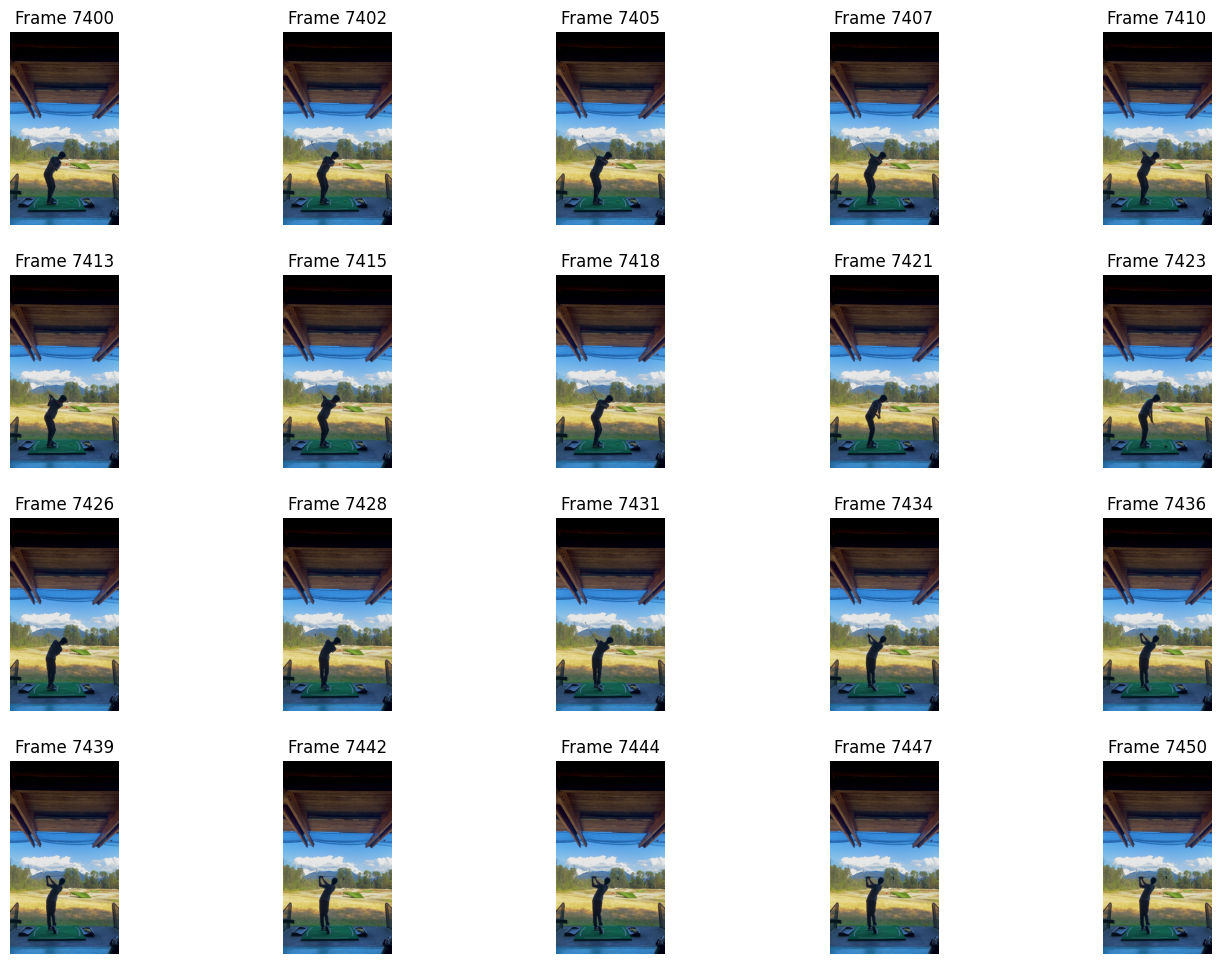

In [22]:
plotter.combined_plot(
    start_frame=7400,
    end_frame=7450,
    num_frames=20
)